Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Instead of `RidgeRegression`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `RidgeRegression`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module3')

In [2]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [3]:
!pip install pandas_profiling

In [58]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [60]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [61]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [62]:
df.T.head(30)

,0,1,2,3,4,5,6,7,8,9,...,23030,23031,23032,23033,23034,23035,23036,23037,23038,23039
BOROUGH,1,1,1,1,1,1,1,2,2,2,...,4,4,4,4,4,4,4,4,4,4
NEIGHBORHOOD,OTHER,OTHER,OTHER,OTHER,UPPER EAST SIDE (59-79),UPPER EAST SIDE (79-96),OTHER,OTHER,OTHER,OTHER,...,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER
BUILDING_CLASS_CATEGORY,13 CONDOS - ELEVATOR APARTMENTS,21 OFFICE BUILDINGS,21 OFFICE BUILDINGS,13 CONDOS - ELEVATOR APARTMENTS,15 CONDOS - 2-10 UNIT RESIDENTIAL,07 RENTALS - WALKUP APARTMENTS,07 RENTALS - WALKUP APARTMENTS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,...,02 TWO FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,02 TWO FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,09 COOPS - WALKUP APARTMENTS,10 COOPS - ELEVATOR APARTMENTS,02 TWO FAMILY DWELLINGS,12 CONDOS - WALKUP APARTMENTS
TAX_CLASS_AT_PRESENT,2,4,4,2,2C,2B,2B,1,1,1,...,1,1,1,1,1,1,2,2,1,2
BLOCK,716,812,839,592,1379,1551,1891,4090,4120,4120,...,10162,11612,11808,12295,12536,10965,169,131,8932,1216
LOT,1246,68,69,1041,1402,131,159,37,18,20,...,52,73,50,23,38,276,29,4,18,1161
EASE-MENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BUILDING_CLASS_AT_PRESENT,R4,O5,O5,R4,R1,C4,C4,A1,A5,A5,...,B1,A1,A0,A1,B3,A5,C6,D4,S2,R2
ADDRESS,"447 WEST 18TH STREET, PH12A",144 WEST 37TH STREET,40 WEST 38TH STREET,"1 SHERIDAN SQUARE, 8C","20 EAST 65TH STREET, B",354 EAST 89TH STREET,304 WEST 106 STREET,1193 SACKET AVENUE,1215 VAN NEST AVENUE,1211 VAN NEST AVENUE,...,104-59 164TH STREET,10919 132ND STREET,135-24 122ND STREET,134-34 157TH STREET,130-26 176 PLACE,111-17 FRANCIS LEWIS BLVD,"45-14 43RD STREET, 3C","50-05 43RD AVENUE, 3M",91-10 JAMAICA AVE,"61-05 39TH AVENUE, F5"
APARTMENT_NUMBER,PH12A,NaN,NaN,8C,B,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F5


In [63]:
df.isnull().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
EASE-MENT                         23040
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64

In [9]:
import numpy as np

df = df.replace( '########',np.NaN, regex=True)

In [10]:
key = ['ZIP_CODE', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'SALE_PRICE']
replace= [-148.0,-147.0,-1.0]
df[key] = df[key].replace( replace,np.NaN, regex=True)

In [11]:
df.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [12]:
df = df.drop(columns = ['APARTMENT_NUMBER', 'EASE-MENT'])

In [13]:
cols_mode = ['TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS']

for column in cols_mode:
    df[column].fillna(df[column].mode()[0], inplace=True)

#'YEAR_BUILT' TOTAL_UNITS  GROSS_SQUARE_FEET LAND_SQUARE_FEET 

In [14]:
df.TOTAL_UNITS = df.RESIDENTIAL_UNITS + df.COMMERCIAL_UNITS

In [15]:
df['LAND_SQUARE_FEET'] = (
    df['LAND_SQUARE_FEET']
    .str.replace(',','')
)
df['LAND_SQUARE_FEET']= df['LAND_SQUARE_FEET'].astype('float64')

In [16]:
cols_mean = ['YEAR_BUILT', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET','LAND_SQUARE_FEET']

for column in cols_mean:
    df[column].fillna(df[column].mean(), inplace=True)

In [17]:
df.T.head(21)

,0,1,2,3,4,5,6,7,8,9,...,23030,23031,23032,23033,23034,23035,23036,23037,23038,23039
BOROUGH,1,1,1,1,1,1,1,2,2,2,...,4,4,4,4,4,4,4,4,4,4
NEIGHBORHOOD,OTHER,OTHER,OTHER,OTHER,UPPER EAST SIDE (59-79),UPPER EAST SIDE (79-96),OTHER,OTHER,OTHER,OTHER,...,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER
BUILDING_CLASS_CATEGORY,13 CONDOS - ELEVATOR APARTMENTS,21 OFFICE BUILDINGS,21 OFFICE BUILDINGS,13 CONDOS - ELEVATOR APARTMENTS,15 CONDOS - 2-10 UNIT RESIDENTIAL,07 RENTALS - WALKUP APARTMENTS,07 RENTALS - WALKUP APARTMENTS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,...,02 TWO FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,02 TWO FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,09 COOPS - WALKUP APARTMENTS,10 COOPS - ELEVATOR APARTMENTS,02 TWO FAMILY DWELLINGS,12 CONDOS - WALKUP APARTMENTS
TAX_CLASS_AT_PRESENT,2,4,4,2,2C,2B,2B,1,1,1,...,1,1,1,1,1,1,2,2,1,2
BLOCK,716,812,839,592,1379,1551,1891,4090,4120,4120,...,10162,11612,11808,12295,12536,10965,169,131,8932,1216
LOT,1246,68,69,1041,1402,131,159,37,18,20,...,52,73,50,23,38,276,29,4,18,1161
BUILDING_CLASS_AT_PRESENT,R4,O5,O5,R4,R1,C4,C4,A1,A5,A5,...,B1,A1,A0,A1,B3,A5,C6,D4,S2,R2
ADDRESS,"447 WEST 18TH STREET, PH12A",144 WEST 37TH STREET,40 WEST 38TH STREET,"1 SHERIDAN SQUARE, 8C","20 EAST 65TH STREET, B",354 EAST 89TH STREET,304 WEST 106 STREET,1193 SACKET AVENUE,1215 VAN NEST AVENUE,1211 VAN NEST AVENUE,...,104-59 164TH STREET,10919 132ND STREET,135-24 122ND STREET,134-34 157TH STREET,130-26 176 PLACE,111-17 FRANCIS LEWIS BLVD,"45-14 43RD STREET, 3C","50-05 43RD AVENUE, 3M",91-10 JAMAICA AVE,"61-05 39TH AVENUE, F5"
ZIP_CODE,10011,10018,10018,10014,10065,10128,10025,10461,10461,10461,...,11433,11420,11420,11434,11434,11429,11104,11377,11421,11377
RESIDENTIAL_UNITS,1,0,0,1,1,10,10,1,1,1,...,2,1,1,1,2,1,0,0,2,1


In [64]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
BLOCK,23040.0,4.459116e+03,3.713270e+03,1.0,1341.0,3546.0,6673.75,16350.0
LOT,23040.0,3.539485e+02,6.280253e+02,1.0,22.0,49.0,375.00,9057.0
EASE-MENT,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZIP_CODE,23039.0,1.079119e+04,1.103414e+03,0.0,10306.0,11211.0,11360.00,11697.0
RESIDENTIAL_UNITS,23039.0,1.827423e+00,1.009043e+01,0.0,0.0,1.0,2.00,750.0
COMMERCIAL_UNITS,23039.0,2.865142e-01,5.778224e+00,-148.0,0.0,0.0,0.00,570.0
TOTAL_UNITS,23039.0,2.320891e+00,1.207055e+01,0.0,1.0,1.0,2.00,755.0
GROSS_SQUARE_FEET,23039.0,3.508555e+03,2.218610e+04,0.0,494.0,1356.0,2280.00,1303935.0
YEAR_BUILT,23005.0,1.819672e+03,4.883766e+02,0.0,1920.0,1940.0,1965.00,2019.0
TAX_CLASS_AT_TIME_OF_SALE,23040.0,1.624479e+00,8.038978e-01,1.0,1.0,1.0,2.00,4.0


In [19]:
key = ['ZIP_CODE','LAND_SQUARE_FEET',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT']
replace= [0.0]
df[key] = df[key].replace( replace,np.NaN, regex=True)

In [20]:
cols_mean = ['ZIP_CODE','LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'SALE_PRICE']

for column in cols_mean:
    df[column].fillna(df[column].mean(), inplace=True)

In [21]:
key = ['ZIP_CODE', 'BLOCK', 'LOT', 'TAX_CLASS_AT_TIME_OF_SALE']
df[key] = df[key].astype(str)

In [22]:
from datetime import datetime
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])
train = df[df['SALE_DATE']<='2019-03-31']
test = df[df['SALE_DATE']> '2019-03-31']

In [23]:
train.T.head(19)

,0,1,2,3,4,5,6,7,8,9,...,18157,18158,18159,18160,18161,18162,18163,18164,18165,18166
BOROUGH,1,1,1,1,1,1,1,2,2,2,...,3,3,3,4,4,4,4,4,4,5
NEIGHBORHOOD,OTHER,OTHER,OTHER,OTHER,UPPER EAST SIDE (59-79),UPPER EAST SIDE (79-96),OTHER,OTHER,OTHER,OTHER,...,OTHER,OTHER,OTHER,ASTORIA,OTHER,OTHER,FLUSHING-NORTH,OTHER,OTHER,OTHER
BUILDING_CLASS_CATEGORY,13 CONDOS - ELEVATOR APARTMENTS,21 OFFICE BUILDINGS,21 OFFICE BUILDINGS,13 CONDOS - ELEVATOR APARTMENTS,15 CONDOS - 2-10 UNIT RESIDENTIAL,07 RENTALS - WALKUP APARTMENTS,07 RENTALS - WALKUP APARTMENTS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,...,13 CONDOS - ELEVATOR APARTMENTS,03 THREE FAMILY DWELLINGS,02 TWO FAMILY DWELLINGS,02 TWO FAMILY DWELLINGS,14 RENTALS - 4-10 UNIT,02 TWO FAMILY DWELLINGS,13 CONDOS - ELEVATOR APARTMENTS,02 TWO FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,02 TWO FAMILY DWELLINGS
TAX_CLASS_AT_PRESENT,2,4,4,2,2C,2B,2B,1,1,1,...,2,1,1,1,2A,1,2,1,1,1
BLOCK,716,812,839,592,1379,1551,1891,4090,4120,4120,...,8720,7806,6708,723,1723,15763,5137,9854,8133,4960
LOT,1246,68,69,1041,1402,131,159,37,18,20,...,1551,29,11,28,1,13,1243,3,24,16
BUILDING_CLASS_AT_PRESENT,R4,O5,O5,R4,R1,C4,C4,A1,A5,A5,...,R4,C0,B9,B1,S9,B2,R4,S2,A1,B9
ADDRESS,"447 WEST 18TH STREET, PH12A",144 WEST 37TH STREET,40 WEST 38TH STREET,"1 SHERIDAN SQUARE, 8C","20 EAST 65TH STREET, B",354 EAST 89TH STREET,304 WEST 106 STREET,1193 SACKET AVENUE,1215 VAN NEST AVENUE,1211 VAN NEST AVENUE,...,"40 OCEANA DRIVE WEST, 4D",1107 EAST 58TH STREET,908 EAST 16TH STREET,3225 47TH STREET,108-02 NORTHERN BOULEVARD,23-72 BROOKHAVEN AVENUE,"138-35 ELDER AVENUE, 4D",84-45 164TH STREET,43-11 LITTLE NECK PARKWAY,3270 AMBOY ROAD
ZIP_CODE,10011.0,10018.0,10018.0,10014.0,10065.0,10128.0,10025.0,10461.0,10461.0,10461.0,...,11235.0,11234.0,11230.0,11103.0,11368.0,11691.0,11355.0,11432.0,11363.0,10306.0
RESIDENTIAL_UNITS,1,0,0,1,1,10,10,1,1,1,...,1,3,2,2,4,2,1,2,1,2


In [24]:
test.T.head(19)

,18167,18168,18169,18170,18171,18172,18173,18174,18175,18176,...,23030,23031,23032,23033,23034,23035,23036,23037,23038,23039
BOROUGH,1,1,1,1,1,1,1,1,1,1,...,4,4,4,4,4,4,4,4,4,4
NEIGHBORHOOD,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,GRAMERCY,GRAMERCY,GRAMERCY,...,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER
BUILDING_CLASS_CATEGORY,13 CONDOS - ELEVATOR APARTMENTS,13 CONDOS - ELEVATOR APARTMENTS,13 CONDOS - ELEVATOR APARTMENTS,17 CONDO COOPS,21 OFFICE BUILDINGS,15 CONDOS - 2-10 UNIT RESIDENTIAL,13 CONDOS - ELEVATOR APARTMENTS,10 COOPS - ELEVATOR APARTMENTS,13 CONDOS - ELEVATOR APARTMENTS,13 CONDOS - ELEVATOR APARTMENTS,...,02 TWO FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,02 TWO FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,09 COOPS - WALKUP APARTMENTS,10 COOPS - ELEVATOR APARTMENTS,02 TWO FAMILY DWELLINGS,12 CONDOS - WALKUP APARTMENTS
TAX_CLASS_AT_PRESENT,2,2,2,2,4,2C,2,2,2,2,...,1,1,1,1,1,1,2,2,1,2
BLOCK,695,767,767,721,746,145,31,880,878,878,...,10162,11612,11808,12295,12536,10965,169,131,8932,1216
LOT,1562,1609,1612,1008,64,1203,1050,42,1010,1059,...,52,73,50,23,38,276,29,4,18,1161
BUILDING_CLASS_AT_PRESENT,R4,R4,R4,R9,O8,R1,R4,D4,R4,R4,...,B1,A1,A0,A1,B3,A5,C6,D4,S2,R2
ADDRESS,"555 WEST 23RD STREET, N11E","221 WEST 17TH STREET, 6A","221 WEST 17TH STREET, PH3","465 WEST 23RD STREET, RCU1",340 WEST 23RD STREET,"109 READE STREET, D","75 WALL STREET, 21I","330 THIRD AVENUE, 18K","121 EAST 22ND STREET, N204","121 EAST 22ND STREET, N804",...,104-59 164TH STREET,10919 132ND STREET,135-24 122ND STREET,134-34 157TH STREET,130-26 176 PLACE,111-17 FRANCIS LEWIS BLVD,"45-14 43RD STREET, 3C","50-05 43RD AVENUE, 3M",91-10 JAMAICA AVE,"61-05 39TH AVENUE, F5"
ZIP_CODE,10011.0,10011.0,10011.0,10011.0,10011.0,10013.0,10005.0,10010.0,10010.0,10010.0,...,11433.0,11420.0,11420.0,11434.0,11434.0,11429.0,11104.0,11377.0,11421.0,11377.0
RESIDENTIAL_UNITS,1,1,1,0,3,1,1,0,1,1,...,2,1,1,1,2,1,0,0,2,1


In [25]:
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

,count,unique,top,freq,first,last
TAX_CLASS_AT_TIME_OF_SALE,18167,3,1,9473,NaN,NaN
BOROUGH,18167,5,4,5883,NaN,NaN
TAX_CLASS_AT_PRESENT,18167,10,1,8911,NaN,NaN
NEIGHBORHOOD,18167,11,OTHER,15058,NaN,NaN
BUILDING_CLASS_CATEGORY,18167,43,01 ONE FAMILY DWELLINGS,4094,NaN,NaN
SALE_DATE,18167,90,2019-01-24 00:00:00,480,2019-01-01 00:00:00,2019-03-31 00:00:00
BUILDING_CLASS_AT_PRESENT,18167,140,D4,2640,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,18167,140,D4,2640,NaN,NaN
ZIP_CODE,18167,184,10314.0,296,NaN,NaN
LOT,18167,1326,1,855,NaN,NaN


In [26]:
train.groupby('BOROUGH')['SALE_PRICE'].mean()

BOROUGH
1    3.200017e+06
2    5.736442e+05
3    8.495242e+05
4    7.335611e+05
5    3.947132e+05
Name: SALE_PRICE, dtype: float64

In [27]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'BLOCK', 'LOT', 'SALE_DATE']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [28]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [29]:
X_train.head(20)

,BOROUGH_1,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_UPPER EAST SIDE (79-96),NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,...,BUILDING_CLASS_AT_TIME_OF_SALE_RA,BUILDING_CLASS_AT_TIME_OF_SALE_G4,BUILDING_CLASS_AT_TIME_OF_SALE_V2,BUILDING_CLASS_AT_TIME_OF_SALE_H2,BUILDING_CLASS_AT_TIME_OF_SALE_P9,BUILDING_CLASS_AT_TIME_OF_SALE_W4,BUILDING_CLASS_AT_TIME_OF_SALE_W3,BUILDING_CLASS_AT_TIME_OF_SALE_I7,BUILDING_CLASS_AT_TIME_OF_SALE_H4,BUILDING_CLASS_AT_TIME_OF_SALE_K6
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
from sklearn.feature_selection import f_regression, SelectKBest


selector = SelectKBest(score_func=f_regression, k=100)

# IMPORTANT!
# .fit_transform on the train set
# .transform on test set
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

((18167, 100), (4873, 100))

In [131]:
# Which features were selected?
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)
    
print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
BOROUGH_1
BOROUGH_2
BOROUGH_3
BOROUGH_4
BOROUGH_5
NEIGHBORHOOD_UPPER EAST SIDE (59-79)
BUILDING_CLASS_CATEGORY_13 CONDOS - ELEVATOR APARTMENTS
BUILDING_CLASS_CATEGORY_21 OFFICE BUILDINGS
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
BUILDING_CLASS_CATEGORY_02 TWO FAMILY DWELLINGS
BUILDING_CLASS_CATEGORY_29 COMMERCIAL GARAGES
BUILDING_CLASS_CATEGORY_32 HOSPITAL AND HEALTH FACILITIES
BUILDING_CLASS_CATEGORY_33 EDUCATIONAL FACILITIES
BUILDING_CLASS_CATEGORY_08 RENTALS - ELEVATOR APARTMENTS
BUILDING_CLASS_CATEGORY_22 STORE BUILDINGS
BUILDING_CLASS_CATEGORY_10 COOPS - ELEVATOR APARTMENTS
BUILDING_CLASS_CATEGORY_45 CONDO HOTELS
BUILDING_CLASS_CATEGORY_30 WAREHOUSES
BUILDING_CLASS_CATEGORY_25 LUXURY HOTELS
BUILDING_CLASS_CATEGORY_11A CONDO-RENTALS
BUILDING_CLASS_CATEGORY_28 COMMERCIAL CONDOS
TAX_CLASS_AT_PRESENT_4
TAX_CLASS_AT_PRESENT_1
BUILDING_CLASS_AT_PRESENT_R4
BUILDING_CLASS_AT_PRESENT_O5
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRE

In [132]:
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

numeric = selected_names

test_scaled = X_test[numeric]
train_scaled = X_train[numeric]

In [133]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_scaled)
X_test_scaled = scaler.transform(test_scaled)

In [134]:
X_train_scaled

array([[ 1.98749497, -0.32317803, -0.6301045 , ..., -0.00741943,
        -0.01049294, -0.01484008],
       [ 1.98749497, -0.32317803, -0.6301045 , ..., -0.00741943,
        -0.01049294, -0.01484008],
       [ 1.98749497, -0.32317803, -0.6301045 , ..., -0.00741943,
        -0.01049294, -0.01484008],
       ...,
       [-0.50314593, -0.32317803, -0.6301045 , ..., -0.00741943,
        -0.01049294, -0.01484008],
       [-0.50314593, -0.32317803, -0.6301045 , ..., -0.00741943,
        -0.01049294, -0.01484008],
       [-0.50314593, -0.32317803, -0.6301045 , ..., -0.00741943,
        -0.01049294, -0.01484008]])

In [135]:
X_test_scaled

array([[ 1.98749497, -0.32317803, -0.6301045 , ..., -0.00741943,
        -0.01049294, -0.01484008],
       [ 1.98749497, -0.32317803, -0.6301045 , ..., -0.00741943,
        -0.01049294, -0.01484008],
       [ 1.98749497, -0.32317803, -0.6301045 , ..., -0.00741943,
        -0.01049294, -0.01484008],
       ...,
       [-0.50314593, -0.32317803, -0.6301045 , ..., -0.00741943,
        -0.01049294, -0.01484008],
       [-0.50314593, -0.32317803, -0.6301045 , ..., -0.00741943,
        -0.01049294, -0.01484008],
       [-0.50314593, -0.32317803, -0.6301045 , ..., -0.00741943,
        -0.01049294, -0.01484008]])

In [136]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [137]:
lin_reg = LinearRegression().fit(train_scaled,y_train)
mean_squared_error(y_train, lin_reg.predict(X_train_scaled))

7.459013774791628e+17

In [138]:
lin_reg = LinearRegression().fit(train_scaled,y_train)
mean_squared_error(y_test, lin_reg.predict(X_test_scaled))

9.056880467320149e+16

In [139]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge().fit(X_train, y_train)
mean_squared_error(y_train, ridge_reg.predict(X_train))

38011039971221.82

In [140]:
ridge_reg = Ridge().fit(X_train_scaled, y_train)
mean_squared_error(y_train, ridge_reg.predict(X_train_scaled))

34963151111877.977

In [141]:
ridge_reg = Ridge().fit(X_train_scaled, y_train)
mean_squared_error(y_test, ridge_reg.predict(X_test_scaled))

67827873334207.945

In [111]:
alphas = []
mses = []

for alpha in range(1, 200, 1):
    ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
    mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
    print(alpha, mse)
    alphas.append(alpha)
    mses.append(mse)

1 73873769339164.34
2 75581928391281.95
3 76536122747626.98
4 77089164107514.25
5 77423833497816.28
6 77631739272938.75
7 77761601514567.2
8 77841044778931.61
9 77886642881712.64
10 77908825903998.8
11 77914425011946.95
12 77908066076398.33
13 77892970408049.22
14 77871434565370.22
15 77845128596435.56
16 77815287464598.36
17 77782837422285.98
18 77748481533585.83
19 77712758833484.16
20 77676086054137.33
21 77638787569393.66
22 77601117219387.94
23 77563274439321.38
24 77525416328629.31
25 77487666784599.69
26 77450123485192.6
27 77412863277043.56
28 77375946367898.94
29 77339419613756.47
30 77303319114165.95
31 77267672274322.77
32 77232499452991.06
33 77197815286389.97
34 77163629756867.25
35 77129949059317.69
36 77096776306397.48
37 77064112104566.05
38 77031955026110.92
39 77000301997028.44
40 76969148616543.2
41 76938489420871.27
42 76908318101338.44
43 76878627685005.62
44 76849410684400.08
45 76820659221714.83
46 76792365131853.6
47 76764520047902.94
48 76737115471976.64
49 767

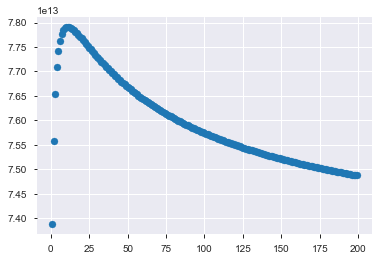

In [112]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(alphas, mses);

In [148]:
alphas = []
mses = []

for alpha in range(1, 100, 1):
    ridge_reg_split = Ridge(alpha=alpha).fit(X_train_scaled, y_train)
    mse = mean_squared_error(y_train, ridge_reg_split.predict(X_train_scaled))
    print(alpha, mse)
    alphas.append(alpha)
    mses.append(mse)

1 34963151111877.977
2 34963156660839.324
3 34963164854757.973
4 34963175258878.773
5 34963187615491.164
6 34963201761607.133
7 34963217586822.707
8 34963235010822.83
9 34963253970960.93
10 34963274415214.285
11 34963296298103.76
12 34963319578292.95
13 34963344217160.31
14 34963370177945.203
15 34963397425236.93
16 34963425924670.805
17 34963455642749.8
18 34963486546742.316
19 34963518604625.82
20 34963551785057.65
21 34963586057361.383
22 34963621391521.805
23 34963657758183.938
24 34963695128653.637
25 34963733474897.957
26 34963772769544.996
27 34963812985882.0
28 34963854097852.312
29 34963896080050.574
30 34963938907716.695
31 34963982556728.414
32 34964027003592.79
33 34964072225436.684
34 34964118199996.39
35 34964164905606.7
36 34964212321189.277
37 34964260426240.71
38 34964309200820.18
39 34964358625536.953
40 34964408681537.688
41 34964459350493.66
42 34964510614588.066
43 34964562456503.203
44 34964614859407.848
45 34964667806944.695
46 34964721283218.035
47 3496477527278

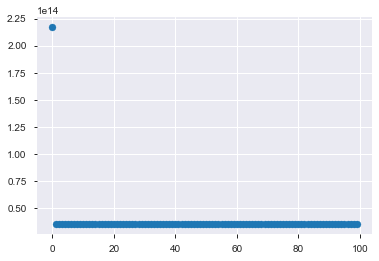

In [147]:

plt.scatter(alphas, mses);

In [142]:
alphas = []
mses = []

for alpha in range(1, 100, 1):
    ridge_reg_split = Ridge(alpha=alpha).fit(X_train_scaled, y_train)
    mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test_scaled))
    print(alpha, mse)
    alphas.append(alpha)
    mses.append(mse)

1 67827873334207.945
2 67826079419646.45
3 67824402042435.15
4 67822811211355.46
5 67821286562048.016
6 67819813780892.02
7 67818382511812.69
8 67816985075343.27
9 67815615654738.55
10 67814269761940.94
11 67812943877269.805
12 67811635200321.18
13 67810341474006.5
14 67809060857853.96
15 67807791835204.586
16 67806533144178.0
17 67805283725597.55
18 67804042683205.54
19 67802809252913.266
20 67801582778778.69
21 67800362694055.64
22 67799148506106.71
23 67797939784291.27
24 67796736150165.31
25 67795537269493.89
26 67794342845696.59
27 67793152614434.17
28 67791966339111.3
29 67790783807118.555
30 67789604826676.234
31 67788429224169.54
32 67787256841888.36
33 67786087536101.484
34 67784921175408.555
35 67783757639324.21
36 67782596817056.78
37 67781438606451.08
38 67780282913069.85
39 67779129649393.09
40 67777978734117.81
41 67776830091543.83
42 67775683651033.266
43 67774539346533.76
44 67773397116156.48
45 67772256901801.83
46 67771118648826.625
47 67769982305747.23
48 67768847823

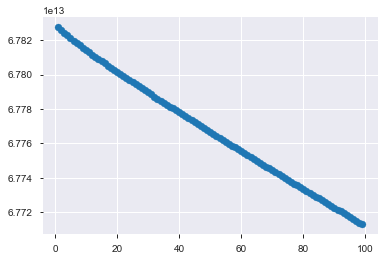

In [143]:

plt.scatter(alphas, mses);